In [14]:
import re
import numpy as np
import pandas as pd
import xarray as xr
from datetime import datetime

def _time_from_date_and_time_line(ln: str):
    """Parse lines like: 20240925.000000                         date and time"""
    if "date and time" not in ln.lower():
        return None
    tok = ln.split()[0]
    if "." in tok:
        ymd, hms = tok.split(".")
    else:
        return None
    if len(hms) == 4:   # YYYYMMDD.HHMM
        hms = hms + "00"
    dt = datetime.strptime(ymd + hms, "%Y%m%d%H%M%S")
    return np.datetime64(dt)

def _read_block_floats(lines, i, nvals):
    vals = []
    j = i
    while len(vals) < nvals and j < len(lines):
        line = lines[j].strip()
        if line:
            vals.extend([float(t) for t in line.split()])
        j += 1
    if len(vals) < nvals:
        raise ValueError("Unexpected EOF while reading numeric block.")
    return np.array(vals[:nvals], float), j

def read_swan_spec(path):
    """
    Read a SWAN .spec file variant where QUANT precedes the time-stamp and
    data are FACTOR-scaled integers per time step.
    Returns xr.Dataset with S2d(time,freq,dir) and diagnostics.
    """
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        lines = [ln.rstrip("\n") for ln in f]

    # ---------- Pass 1: read NDIR/dir list and AFREQ/freq list (constant over time) ----------
    ND = None; NF = None; direc = None; freq = None
    i = 0
    n = len(lines)
    
    def _next_nonempty(j):
        while j < n and not lines[j].strip():
            j += 1
        return j
    
    while i < n:
        u = lines[i].strip().upper()
    
        # Absolute frequencies
        if u.startswith(("AFREQ", "FREQ", "RFREQ")):
            # Next non-empty line contains: "<NF>  number of frequencies"
            i = _next_nonempty(i + 1)
            m = re.match(r"^\s*(\d+)", lines[i])
            if not m:
                raise ValueError("Could not parse NFREQ after AFREQ/FREQ.")
            NF = int(m.group(1))
            # The following lines contain NF floats (1 per line or packed)
            freq, i = _read_block_floats(lines, i + 1, NF)
            continue
    
        # Directions
        if u.startswith(("CDIR", "DIR", "CGRID")):
            # Next non-empty line contains: "<ND>  number of directions"
            i = _next_nonempty(i + 1)
            m = re.match(r"^\s*(\d+)", lines[i])
            if not m:
                raise ValueError("Could not parse NDIR after CDIR/DIR.")
            ND = int(m.group(1))
            # Next lines contain ND floats (often one per line)
            direc, i = _read_block_floats(lines, i + 1, ND)
            continue
    
        i += 1
    
    if NF is None or ND is None:
        raise ValueError("Missing NFREQ or NDIR in header.")
    
    # Ensure numpy arrays
    freq  = np.asarray(freq,  float)
    direc = np.asarray(direc, float)

    # ---------- Pass 2: iterate time blocks starting at QUANT ----------
    times = []
    spectra = []
    i = 0
    while i < len(lines):
        u = lines[i].strip().upper()
        if not u.startswith("QUANT"):
            i += 1
            continue

        # QUANT header: may be just 'QUANT' on its own line
        i += 1
        # Next line often: "<NQ>  number of quantities in table"
        if i >= len(lines): break
        line = lines[i].strip()
        m = re.match(r"^\s*(\d+)", line)
        NQ = int(m.group(1)) if m else 1
        i += 1

        # Next: quantity name (first quantity is 2D variance density)
        if i >= len(lines): break
        qname = lines[i].strip().split()[0]  # e.g., "VaDens"
        i += 1

        # Next: unit string on its own line
        if i >= len(lines): break
        units_2d = lines[i].strip().split()[0]  # e.g., "m2/Hz/degr"
        i += 1

        # Next: exception value (float)
        if i >= len(lines): break
        exc_line = lines[i].strip()
        try:
            exc_value = float(exc_line.split()[0])
        except Exception:
            exc_value = None
        i += 1

        # Next lines until we hit a 'date and time' line
        tstamp = None
        while i < len(lines) and tstamp is None:
            tstamp = _time_from_date_and_time_line(lines[i].strip())
            i += 1
        if tstamp is None:
            raise ValueError("Timestamp ('date and time') not found after QUANT block.")
        times.append(tstamp)

        # Optional FACTOR
        factor = 1.0
        if i < len(lines) and lines[i].strip().upper().startswith("FACTOR"):
            i += 1
            if i < len(lines):
                try:
                    factor = float(lines[i].strip().split()[0])
                except Exception:
                    factor = 1.0
                i += 1

        # Now read NF * ND numbers for the **first** quantity.
        # Many files store them as integers that need multiplying by FACTOR.
        nvals = NF * ND
        vals, i = _read_block_floats(lines, i, nvals)
        S2 = factor * vals.reshape(NF, ND)

        # If there are more quantities (NQ>1), skip their blocks of the same size
        for _ in range(1, NQ):
            _, i = _read_block_floats(lines, i, nvals)

        # Apply exception value → NaN
        if exc_value is not None:
            S2 = np.where(np.isclose(S2, exc_value, atol=0), np.nan, S2)

        spectra.append(S2)

    if not spectra:
        raise ValueError("No spectra blocks found (QUANT sections not parsed).")

    time = np.array(times, dtype="datetime64[ns]")
    freq = np.asarray(freq, float)
    direc = np.asarray(direc, float)
    S2d = np.stack(spectra, axis=0).astype("float32")  # (time, NF, ND)

    ds = xr.Dataset(
        data_vars=dict(
            S2d=(("time","freq","dir"), S2d),
        ),
        coords=dict(
            time=time, freq=freq, dir=direc
        ),
        attrs=dict(
            source="SWAN .spec reader (QUANT-before-time, FACTOR-scaled)",
            units_S2d=units_2d,  # e.g., 'm2/Hz/degr'
        )
    )

    # ---- Diagnostics: Ef, Dth, m0, Hs (respect deg vs rad units) ----
    units = (units_2d or "").lower()
    per_degree = ("/deg" in units) or ("/degr" in units)
    if per_degree:
        # Convert deg columns to radians during integration
        ds["Ef"]  = (ds.S2d * np.deg2rad(1.0)).integrate("dir").astype("float32")  # m^2/Hz
        ds["Dth"] = (ds.S2d * np.deg2rad(1.0)).integrate("freq").astype("float32") # m^2 (per rad)
    else:
        ds["Ef"]  = ds.S2d.integrate("dir").astype("float32")
        ds["Dth"] = ds.S2d.integrate("freq").astype("float32")
    ds["m0"] = ds["Ef"].integrate("freq").astype("float32")
    ds["Hs"] = (4.0 * np.sqrt(ds["m0"])).astype("float32")

    return ds


<xarray.Dataset> Size: 7kB
Dimensions:  (time: 1, freq: 41, dir: 36)
Coordinates:
  * time     (time) datetime64[ns] 8B 2024-09-25
  * freq     (freq) float64 328B 0.0314 0.0345 0.038 0.0418 ... 1.174 1.291 1.42
  * dir      (dir) float64 288B 5.0 15.0 25.0 35.0 ... 325.0 335.0 345.0 355.0
Data variables:
    S2d      (time, freq, dir) float32 6kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    Ef       (time, freq) float32 164B 0.0 0.0 0.0 ... 4.301e-06 2.505e-06
    Dth      (time, dir) float32 144B 9.365e-10 1.038e-08 3.961e-08 ... 0.0 0.0
    m0       (time) float32 4B 0.000288
    Hs       (time) float32 4B 0.06788
Attributes:
    source:     SWAN .spec reader (QUANT-before-time, FACTOR-scaled)
    units_S2d:  m2/Hz/degr


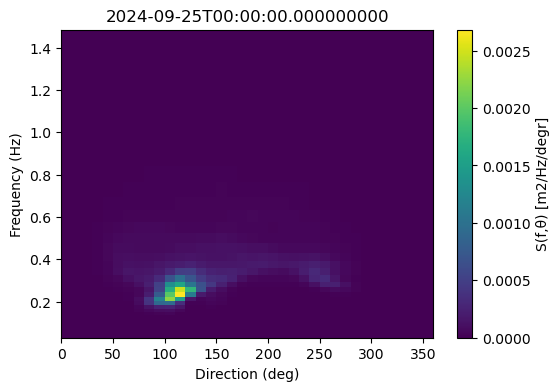

In [15]:
data_dir = 'F:/crs/proj/2025_NOPP_comparison/helene_adcirc_model_results/spec_files/'

ds_spec = read_swan_spec(data_dir+"bnd300.spc")

print(ds_spec)
# <xarray.Dataset>
# Dimensions: (time: T, freq: NF, dir: ND)
# Data variables:
#   S2d   (time, freq, dir) float32 ...
#   Ef    (time, freq)      float32 ...
#   Dth   (time, dir)       float32 ...
#   m0    (time)            float32 ...
#   Hs    (time)            float32 ...
# Coordinates:
#   time  (time) datetime64[ns] ...
#   freq  (freq) float64 ...
#   dir   (dir)  float64 ...

# Example: plot a snapshot 2D spectrum at time index k
k = 0
S = ds_spec.S2d.isel(time=k)
# pcolormesh expects edges; quick-and-dirty centers are fine:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
pc = plt.pcolormesh(ds_spec.dir, ds_spec.freq, S, shading='auto')
plt.xlabel("Direction (deg)")
plt.ylabel("Frequency (Hz)")
plt.colorbar(pc, label=f"S(f,θ) [{ds_spec.attrs['units_S2d']}]")
plt.title(str(np.datetime_as_string(ds_spec.time.values[k])))
plt.show()
